In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

from saxs_data_processing import io, manipulate, target_comparison, subtract, sasview_fitting
from joblib import Parallel, delayed


import sys
sys.path.append('../visualizations/phase_diagram_viz/')
import utils as pd_utils
import numpy as np
from scipy.spatial.distance import pdist, squareform

## Load data

Load data from optimization round 2 campaign. Since we are looking at reproducibility, look at both RMSE and apdistance campaigns

- Use APdist as metric

In [5]:
synthesis_files = ['/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_01_13_RandomSample/SampleTable_RandomSobol_2025_01_13.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_01_28_80nm_round1/Sample_table_2025_01_28_80nm_Round1_apdist.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_01_28_80nm_round1/Sample_table_2025_01_28_80nmRound1_rmse.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/80nmTarget_round2/Sample_table_2025_01_30_80nm_Round2_apdist.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/80nmTarget_round2/Sample_table_2025_01_30_80nmbatch2_rmse.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_02_03_80nmTarget_Round3/Sample_table_2025_02_03_80nm_Round3_apdist.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_02_03_80nmTarget_Round3/Sample_table_2025_02_03_80nmbatch3_rmse.csv'
                  ] 

In [6]:
fp2name = {'/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_01_13_RandomSample/SampleTable_RandomSobol_2025_01_13.csv':'Round2Random',
           '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_01_28_80nm_round1/Sample_table_2025_01_28_80nm_Round1_apdist.csv':'Opt1_Apdist',
           '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_01_28_80nm_round1/Sample_table_2025_01_28_80nmRound1_rmse.csv':'Opt1_rmse',
           '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/80nmTarget_round2/Sample_table_2025_01_30_80nm_Round2_apdist.csv':'Opt2_apdist',
           '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/80nmTarget_round2/Sample_table_2025_01_30_80nmbatch2_rmse.csv':'Opt2_rmse',
           '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_02_03_80nmTarget_Round3/Sample_table_2025_02_03_80nm_Round3_apdist.csv':'Opt3_apdist',
           '/home/bgpelkie/Code/silica-np-synthesis/OptimizationRound2/2025_02_03_80nmTarget_Round3/Sample_table_2025_02_03_80nmbatch3_rmse.csv':'Opt3_rmse'
          }


In [7]:
random_files = ['Round2Random']
apdist_files = ['Opt1_Apdist', 'Opt2_apdist', 'Opt3_apdist']
rmse_files = ['Opt1_rmse', 'Opt2_rmse', 'Opt3_rmse']

In [8]:
with open('./2025_01_13_RandomSample/constants_Round2_2025_01_13.json', 'rt') as f:
    constants = json.load(f)

In [10]:
synth_table = pd.read_csv('./Complete_synth_table_after_batch3.csv')

In [11]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,well,campaign,...,sample_dilute_vol,dilute_well,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,rmse_distance,experiment_status
0,c563cb4d-d727-437f-9a6a-fef3eccbbe50,222.617091,399.058218,590.750129,487.574561,0.485800,12.367236,0.014890,A1,Round2Random,...,NaN,NaN,1700.0,0.045948,0.082365,0.121930,0.286809,1.522190,0.255116,complete
1,3ef8b92f-f2eb-4134-ad6c-ae3329408457,424.578425,225.592744,374.598586,675.230244,0.254717,23.586966,0.028651,A2,Round2Random,...,NaN,NaN,1700.0,0.087632,0.046562,0.077317,0.397194,1.548249,0.264217,complete
2,0507cf19-673b-4d6b-922e-c21f718ad4fe,290.225034,259.039405,534.588398,616.147162,0.372633,16.123118,0.019498,A3,Round2Random,...,NaN,NaN,1700.0,0.059902,0.053465,0.110338,0.362440,1.489590,0.254219,complete
3,82fc5e1c-5d6e-4ecd-82c3-eb912535a0d7,87.221241,134.097491,46.585717,1432.095551,1.239920,4.845476,0.006080,A4,Round2Random,...,NaN,NaN,1700.0,0.018002,0.027678,0.009615,0.842409,0.991199,0.298204,complete
4,9964ab9f-5b01-4ae2-b492-a1be55ce083f,44.198312,353.311589,274.447630,1028.042468,2.446865,2.455386,0.003029,A5,Round2Random,...,NaN,NaN,1700.0,0.009122,0.072923,0.056646,0.604731,1.429035,0.302280,complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,6835f124-f5d6-43aa-a279-afcb239638af,387.962921,391.025337,726.750029,194.261713,0.278757,21.552834,0.025623,C2,Opt3_rmse,...,474.0,E8,1700.0,0.080075,0.080707,0.150000,0.114272,1.543397,0.267277,complete
88,f33b86ef-abb4-4015-a39e-7a1447404af8,484.500007,249.628718,726.750029,239.121245,0.223214,26.915840,0.032013,C3,Opt3_rmse,...,379.0,F1,1700.0,0.100000,0.051523,0.150000,0.140660,1.326944,0.297241,complete
89,0c9a7a98-4035-453d-ac5c-c95edc1c0de6,203.892761,342.406805,24.224999,1129.475434,0.530413,11.327028,0.014084,C4,Opt3_rmse,...,902.0,F2,1700.0,0.042083,0.070672,0.005000,0.664397,1.531726,0.278223,complete
90,76682cac-1ccd-4f9e-ac77-90854e231547,484.500007,369.326213,726.750029,119.423751,0.223214,26.915840,0.031909,C5,Opt3_rmse,...,379.0,F3,1700.0,0.100000,0.076228,0.150000,0.070249,1.309539,0.278673,complete


### Composition vs AP distance

Text(0.5, 0, 'Water vol frac')

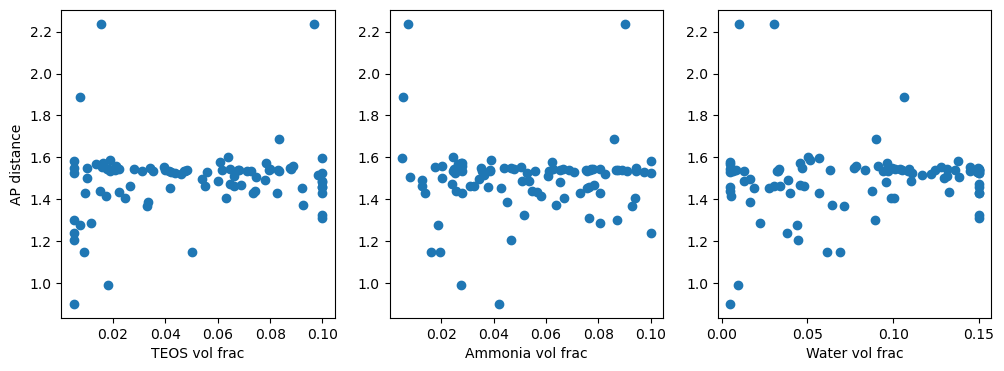

In [12]:
fig, ax = plt.subplots(1,3, figsize = (12,4))

ax[0].scatter(synth_table['teos_vol_frac'], synth_table['ap_distance'])
ax[1].scatter(synth_table['ammonia_vol_frac'], synth_table['ap_distance'])
ax[2].scatter(synth_table['water_vol_frac'], synth_table['ap_distance'])

ax[0].set_ylabel('AP distance')
ax[0].set_xlabel('TEOS vol frac')
ax[1].set_xlabel('Ammonia vol frac')
ax[2].set_xlabel('Water vol frac')

### Distance to next sample vs APdist between samples

For this, need pairwise distance between each sample
- or each sample and it's 5 closest neighbors?
- Take average AP distance
- Can plot this as a metric however we need


In [19]:
with open('./2025_02_05_80nmTarget_Round4/scaled_intensities_Opt2_Batch3.json', 'rt') as f:
    saxs_curves = json.load(f)

In [20]:
def find_n_closest_neighbors(dist_matrix, n):
    """
    Find the n closest neighbors for each point in a list of 3D points.
    
    :param points: List of (x, y, z) tuples or a NumPy array of shape (m, 3)
    :param n: Number of nearest neighbors to find (excluding the point itself)
    :return: Dictionary mapping each point index to a list of n closest neighbor indices
    """


    # Get the indices of the closest neighbors (excluding the point itself)
    neighbors = {}
    for i in range(len(dist_matrix)):
        sorted_indices = np.argsort(dist_matrix[i])  # Sort distances (smallest first)
        closest_n = sorted_indices[1:n+1]  # Exclude the first one (distance to itself = 0)
        neighbors[i] = closest_n.tolist()

    return neighbors

In [21]:
# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

In [22]:
# 1. calculate the pairwise distance between every sample in compoistion space

uuid_list = list(synth_table['uuid'])
compositions = synth_table[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']].to_numpy()

distances = squareform(pdist(compositions, metric = 'euclidean'))
#2. Get the 5 closest neighbors for each sample

neighbors_indices = find_n_closest_neighbors(distances, 5)

#3. Calcualate the AP distance for each pair 


In [24]:
AP_distances = np.load('../computed_ap_distances.npy', allow_pickle=True)

In [25]:
# 4. histogram of neighbor distances vs. ap distances

In [40]:
composition_distances = []
ap_distances_all = []

ap_over_comp_avg = {}
# for each sample:
for ind, neighbs in neighbors_indices.items():
    # for each neighbor:
    comp_dist = []
    ap_dist_neighbs = []
    for ind2 in neighbs:
        composition_distances.append(distances[ind, ind2])
        comp_dist.append(distances[ind, ind2])
        
        ap_distances_all.append(AP_distances[min(ind, ind2), max(ind, ind2)])
        ap_dist_neighbs.append(AP_distances[min(ind, ind2), max(ind, ind2)])

    ratio = []
    for cd, ad in zip(comp_dist, ap_dist_neighbs):
        if cd is None or ad is None:
            continue
        else:
            ratio.append(ad/cd)

    ap_over_comp_avg[ind] = np.mean(ratio)

Text(0, 0.5, 'AP distance')

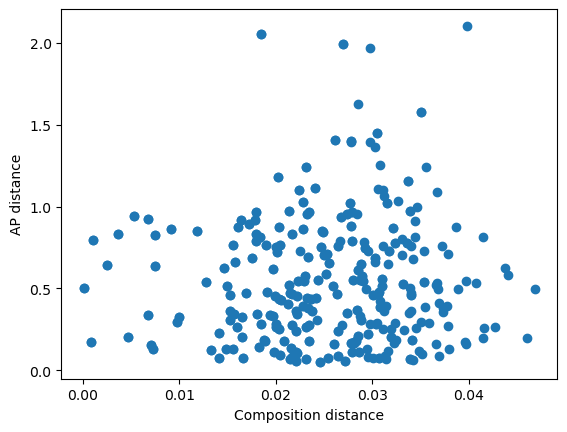

In [27]:
plt.scatter(composition_distances, ap_distances_all)
plt.xlabel('Composition distance')
plt.ylabel('AP distance')

### Plot APdistance/composition distance vs. composition

In [29]:
dist_ratio = []
for ap, comp in zip(ap_distances_all, composition_distances):
    if ap is None or comp is None:
        dist_ratio.append(None)
    else:
        dist_ratio.append(ap/comp)

Text(0, 0.5, 'Average AP dist/composition distance for closest neighbors')

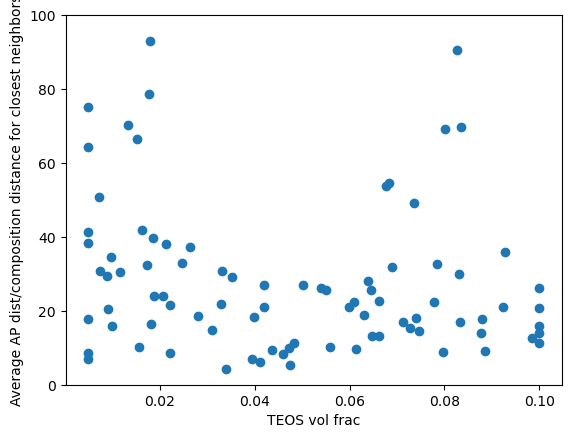

In [49]:
fig, ax = plt.subplots()

x_var = 0


comp_list = []
ratio_list = []
for i, ratio in ap_over_comp_avg.items():
    comp_list.append(compositions[i, x_var])
    ratio_list.append(ratio)

ax.scatter(comp_list, ratio_list)
ax.set_ylim(0, 100)

ax.set_xlabel('TEOS vol frac')
ax.set_ylabel('Average AP dist/composition distance for closest neighbors')

In [32]:
len(dist_ratio)

460

In [35]:
np.array([1,1,None,1])

AttributeError: 'numpy.ndarray' object has no attribute 'isna'